Logistic Regression approach to the downstream tracking.
====================
I would like to use very simple, linear model - Logistic Regresion.  
It will be the easiest to implement in the C++.  

Study roadmap
------------
1. Train basic classifier
2. Normalize features
3. Play with regularization
4. Add class weights to balance training set
5. Add polynomian features 
6. Add feature's ratios 


The baselines scores (ROC_AUC) are 
---------
* kNN 0.787050
* BDT 0.813190


In [1]:
print("kernel is alive!")

kernel is alive!


In [4]:
import root_numpy
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import validation_curve


Welcome to ROOTaaS 6.06/02


As a very first step I need to grab training data form the NTpule. 
--------------------------
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [5]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [6]:
def basic_transforamtion(data):
    #pseudorapidity and seed_r
    out = data
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    return out

In [7]:
data = basic_transforamtion(data)
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty,seed_r,pseudo_rapidity
0,1.213708,7.841285,7.079410,25,0,12,1263.157617,517.249191,0.524220,0.061572,1364.959300,0.505958
1,1.346112,7.930741,7.093734,25,0,12,1264.522435,99.363473,0.480288,0.009081,1268.420312,0.463589
2,1.627632,8.469986,7.443378,25,0,12,1521.093160,196.064807,0.382802,0.025975,1533.677219,0.374842
3,1.789231,8.556975,7.508752,25,0,12,1563.145597,483.850246,0.369674,0.058753,1636.317578,0.366082
4,1.269238,7.741082,7.132965,24,0,12,1641.727752,411.084316,0.646627,0.054980,1692.412576,0.610352


In [8]:
def print_features_histograms(Xdata, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(Xdata):
        # add sub plot on our figure
        ax = fig.add_subplot(Xdata.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(Xdata[feature], [1, 99])
        ax.hist(Xdata.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(Xdata.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

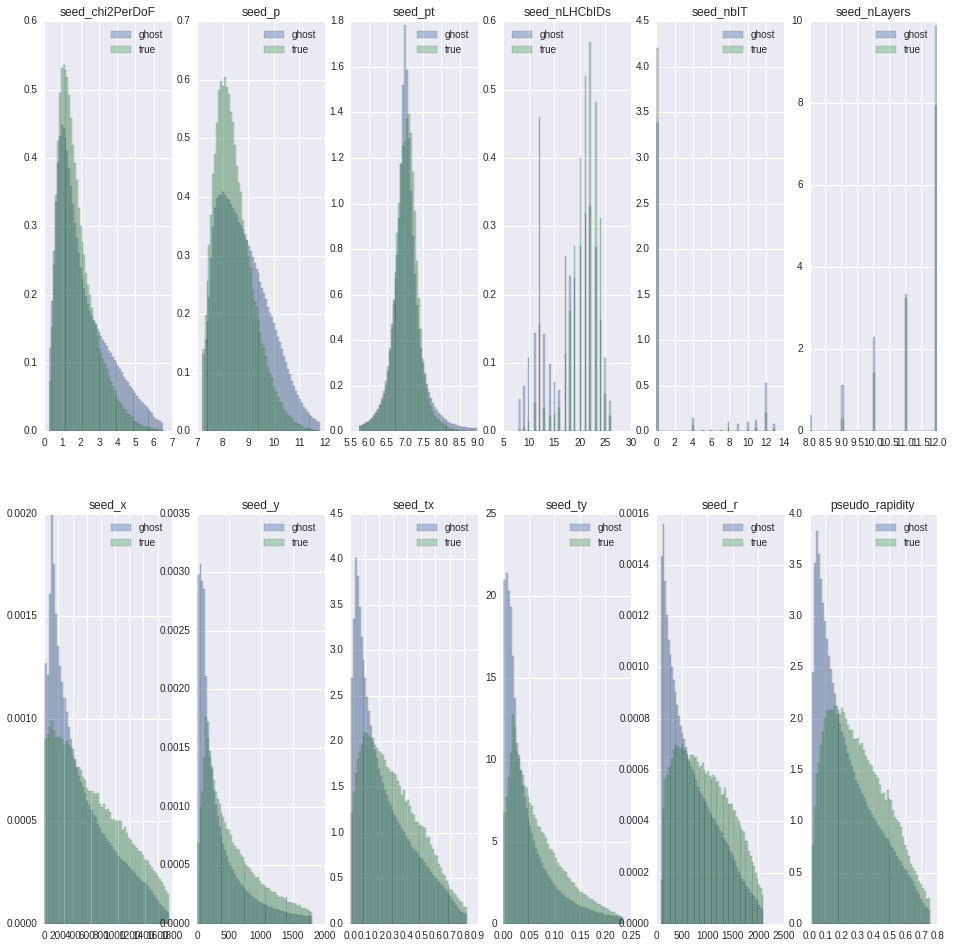

In [12]:
print_features_histograms(features, target)

In [13]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

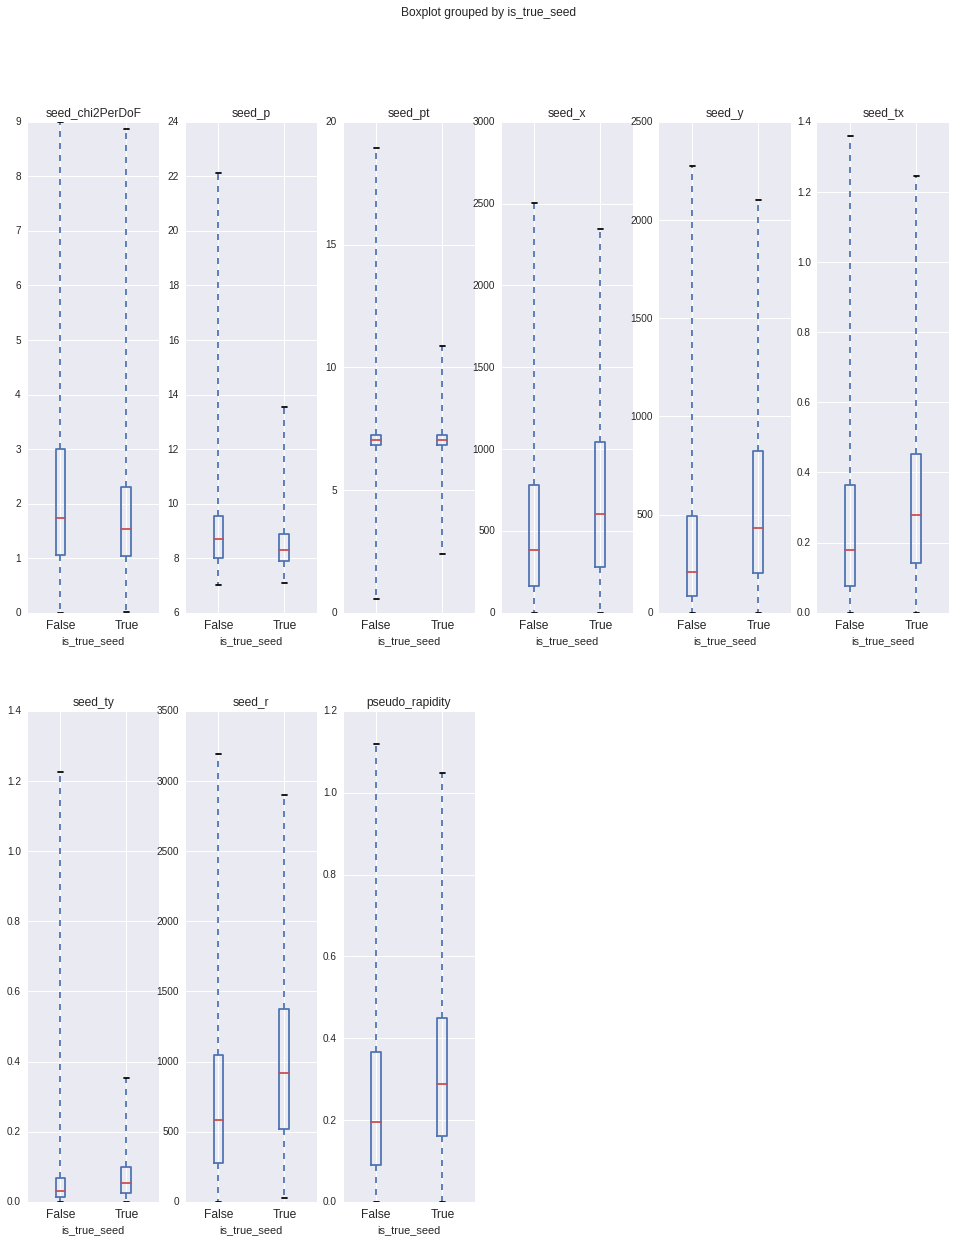

In [14]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

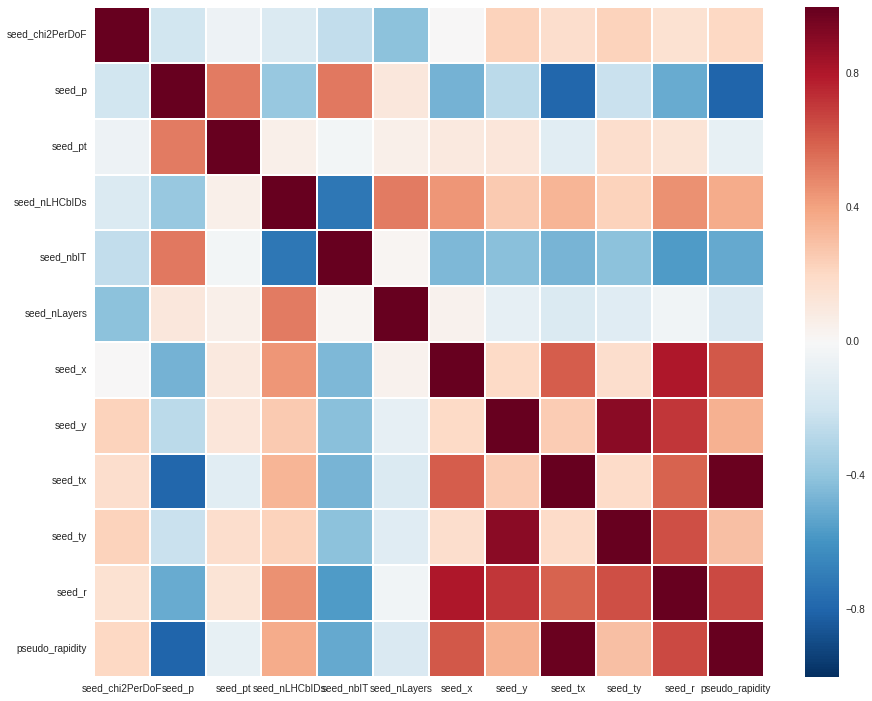

In [15]:
cor_mat = features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

Training of the basic version of the Logistic Regresion
=======================
I use LogisticRegresion with default values of parameters. 

Split data into train and validation sets
----------------------

In [16]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

In [17]:
clf = linear_model.LogisticRegression()
clf.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [18]:
roc_auc_score(testY, clf.predict_proba(testX)[:, 1])

0.73450694591407195

In [13]:
scores = cross_validation.cross_val_score(clf,
                                          features, target,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

Accuracy: 0.73054 (+/- 0.00223)


In [30]:
def print_roc_curve(classifiers, cls_names, validX, validY):
    for classifier, cls_name in zip(classifiers, cls_names):
        fpr, tpr, thresholds = roc_curve(validY, classifier.predict_proba(validX)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=[6, 6])
        plt.plot(fpr, tpr, lw=1, label='ROC %(name)s (area = %(area)0.2f)'%{'name':cls_name,'area':roc_auc })
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

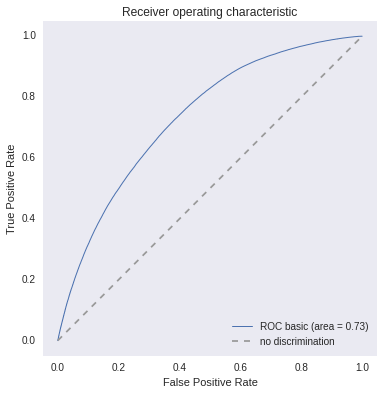

In [20]:
classifiers=[clf]
cls_names = ['basic']
print_roc_curve(classifiers,cls_names,testX,testY)

Now, Let's try to scale all features
-------------------

In [25]:
scaled_trainX, scaled_testX, scaled_trainY, scaled_testY = train_test_split(features, target, random_state=42,train_size=0.5 )

clf_scaled = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4))
])

In [26]:
clf_scaled.fit(scaled_trainX, scaled_trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

In [27]:
roc_auc_score(scaled_testY, clf_scaled.predict_proba(scaled_testX)[:, 1])

0.73891590997933398

In [28]:
clf_scaled_cv = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4))
])
scores = cross_validation.cross_val_score(clf_scaled_cv,
                                          features,target, 
                                          scoring="roc_auc",
                                          n_jobs=8,
                                          cv=3);
print "Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

Accuracy: 0.73904 (+/- 0.00147)


We have small improvement by 0.5% 

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring='roc_auc' , n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = numpy.mean(train_scores, axis=1)
    train_scores_std = numpy.std(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    test_scores_std = numpy.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/afs/cern.ch/sw/lcg/releases/LCG_84/pyanalysis/1.5_python2.7/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/pyplot.pyc'>

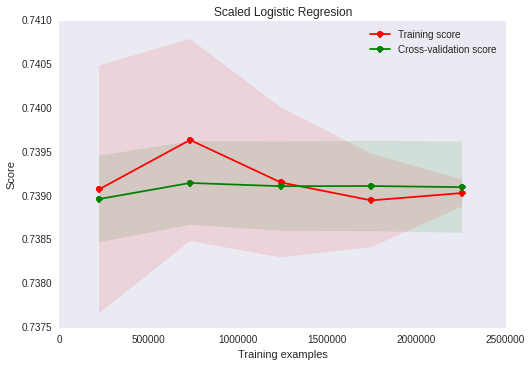

In [31]:
cv = cross_validation.ShuffleSplit(features.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
plot_learning_curve(clf_scaled, 'Scaled Logistic Regresion',features,target, cv=cv )

Play with regularization constans
==============
At first ry to optimalize L1 regularization 
----------------
I use LogisticRegressionCV as a model. It can optimalize strength of regularization in a very easy way. 
Ofcourse as I need to scale the features at first. 

The regularization scale are in range 10^-3 - 100 with pseudologaritmical step 


In [ ]:
cv = cross_validation.ShuffleSplit(scaled_trainX.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

Cs= [0.001,0.003,
    0.01, 0.03,
    0.1,0.3,
    1,3,
    10,30]

clf_scaled = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4 , penalty='l1'))
])


train_scores, test_scores = validation_curve(
    clf_scaled, features, target, param_name="classification__C", param_range=Cs,
    cv=cv, scoring="roc_auc", n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)        

In [62]:
train_scores_mean

array([ 0.73171422,  0.73218308,  0.73234372,  0.73238517,  0.73239823,
        0.73240185,  0.73240307,  0.73240343,  0.73240356,  0.73240359])

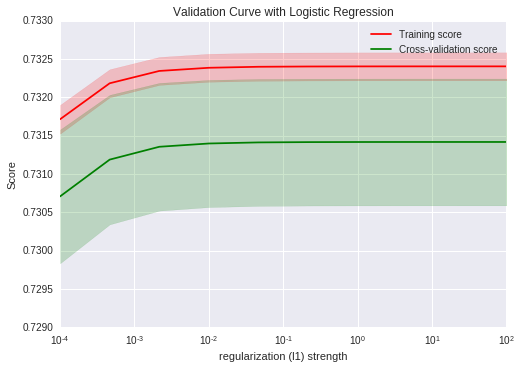

In [65]:
param_range = np.logspace(-4, 2,10)
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("regularization (l1) strength")
plt.ylabel("Score")
plt.ylim(0.729, 0.733)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show() 

Conclusion for L1 study. There is no impact on classifier performance the C > 0.01 

Similar study for L2 regularization.
---------------
The classifier should have worst performance due to distribution of the features. 

In [66]:
cv = cross_validation.ShuffleSplit(scaled_trainX.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

Cs= [0.001,0.003,
    0.01, 0.03,
    0.1,0.3,
    1,3,
    10,30]

clf_scaled = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(tol=1e-4 , penalty='l2'))
])


train_scores, test_scores = validation_curve(
    clf_scaled, features, target, param_name="classification__C", param_range=Cs,
    cv=cv, scoring="roc_auc", n_jobs=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)  

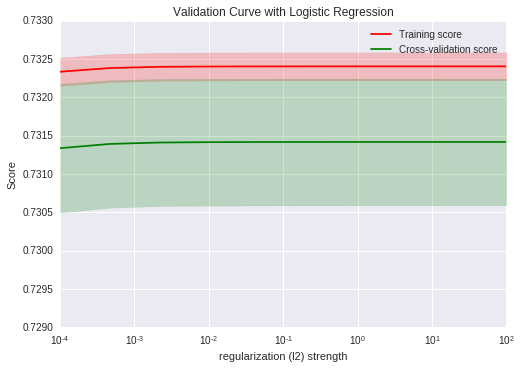

In [67]:
param_range = np.logspace(-4, 2,10)
plt.title("Validation Curve with Logistic Regression")
plt.xlabel("regularization (l2) strength")
plt.ylabel("Score")
plt.ylim(0.729, 0.733)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show() 

Conclusions
------------
I get some knowlage.  
I don't need to add regularization if number of event >> number of hiperparameters! 


Add class weights
---------------
Doue to huge mibalnced of the training set I want to add normlize training dataset.  
At first I need to calculate ratio between good and ghost seeds and round it. 

In [26]:
good_track_no = counts = features[target == 1].count()[0]
ghost_track_no = counts = features[target == 0].count()[0]
print("good tracks %d") % good_track_no
print("ghost track %d") % ghost_track_no
ratio = float(good_track_no)/ghost_track_no
ratio = numpy.round(ratio, 3)
print ("ratio good to ghost %f") % ratio

good tracks 178831
ghost track 2641394
ratio good to ghost 0.068000


In [32]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )

clf_weighted = Pipeline([
  ('feature_scale', StandardScaler() ),
  ('classification', linear_model.LogisticRegression(class_weight={1:(1-0.068), 0:0.068}))
])
clf_weighted.fit(trainX, trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classification', LogisticRegression(C=1.0, class_weight={0: 0.068, 1: 0.9319999999999999},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0))])

In [33]:
roc_auc_score(testY, clf_weighted.predict_proba(testX)[:, 1])

0.7392220070295844

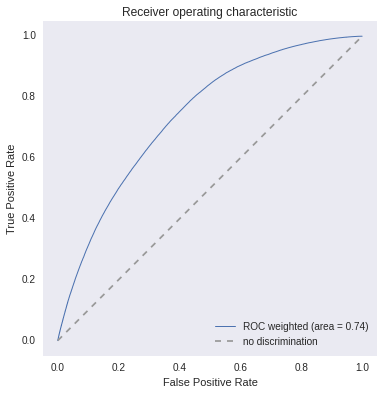

In [34]:
classifiers=[clf_weighted]
cls_names = ['weighted']
print_roc_curve(classifiers,cls_names,testX,testY)

I see small improvement. 
-----------
So I will be using nomrnalization class weight **0.068** for the further studies. 

Add Polynomian features
==================
Add second order of magnitudes polynomian features

In [35]:
clf_polynomian = Pipeline([
          ('feature_scale', StandardScaler() ),
          ('polynomian', PolynomialFeatures(degree=2, include_bias = False)),
          ('classification', linear_model.LogisticRegression(tol=1e-4 , penalty='l2',class_weight={1:(1-0.068), 0:0.068} ))
])

In [36]:
scaled_trainX, scaled_testX, scaled_trainY, scaled_testY = train_test_split(features, target, random_state=42,train_size=0.5 )
clf_polynomian.fit(scaled_trainX, scaled_trainY)

Pipeline(steps=[('feature_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomian', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('classification', LogisticRegression(C=1.0, class_weight={0: 0.068, 1: 0.9319999999999999},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0))])

In [37]:
roc_auc_score(scaled_testY, clf_polynomian.predict_proba(scaled_testX)[:, 1])

0.7724449534557406

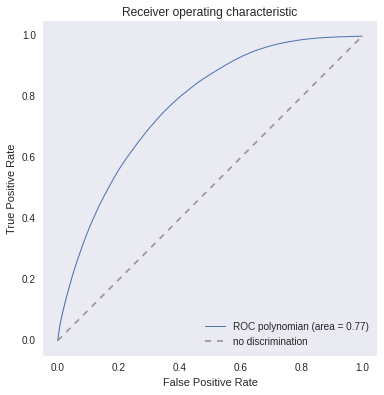

In [38]:
classifiers=[clf_polynomian]
cls_names = ['polynomian']
print_roc_curve(classifiers,cls_names,testX,testY)

Add feature's ratios
------------
I add (in my opinion) the most important feature's ratios to the data set.  
In particular I use: 

* seed_p over chi2perDoF
* seed_pseudorapidity over chi2perDoF
* seed_r over chi2perDOf
* number of cluster in OuterTracker = nlhcb-nbIT

If this idea fail I suppose I am done. There is almost not possible to imporve this model. 

Now you can go to the next model - [Deep Neural Network](https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/DNN.ipynb) 
=================